# DeepDreaming with TensorFlow

>[Loading and displaying the model graph](#loading)

>[Naive feature visualization](#naive)

>[Multiscale image generation](#multiscale)

>[Laplacian Pyramid Gradient Normalization](#laplacian)

>[Playing with feature visualzations](#playing)

>[DeepDream](#deepdream)



This notebook demonstrates a number of Convolutional Neural Network image generation techniques implemented with TensorFlow for fun and science:

- visualize individual feature channels and their combinations to explore the space of patterns learned by the neural network (see [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) galleries)
- embed TensorBoard graph visualizations into Jupyter notebooks
- produce high-resolution images with tiled computation ([example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg))
- use Laplacian Pyramid Gradient Normalization to produce smooth and colorful visuals at low cost
- generate DeepDream-like images with TensorFlow (DogSlugs included)


The network under examination is the [GoogLeNet architecture](http://arxiv.org/abs/1409.4842), trained to classify images into one of 1000 categories of the [ImageNet](http://image-net.org/) dataset. It consists of a set of layers that apply a sequence of transformations to the input image. The parameters of these transformations were determined during the training process by a variant of gradient descent algorithm. The internal image representations may seem obscure, but it is possible to visualize and interpret them. In this notebook we are going to present a few tricks that allow to make these visualizations both efficient to generate and even beautiful. Impatient readers can start with exploring the full galleries of images generated by the method described here for [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) architectures.

http://programtalk.com/vs2/?source=python/3819/deep-learning-samples/tensorflow-samples/embedding_shape.py

http://bamos.github.io/2016/08/09/deep-completion/

http://programtalk.com/python-examples/tensorflow.Graph/?ipage=4

In [1]:
import os
print(os.getcwd())

/notebooks


In [1]:
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

<a id='loading'></a>
## Loading and displaying the model graph

The pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the `tensorflow_inception_graph.pb` file from the archive and set its path to `model_fn` variable. Alternatively you can uncomment and run the following cell to download the network:

In [2]:
#!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

In [2]:
model_fn = 'tensorflow_inception_graph.pb'
# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

#model_fn = 'tensorflow_inception_graph.pb'
model_fn = 'jcaffe.pb'
# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
jcaffe_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-jcaffe_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [5]:
!locate model_fn

/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/estimators/model_fn.py
/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/estimators/model_fn.pyc
/usr/local/lib/python2.7/dist-packages/tensorflow/python/estimator/model_fn.py
/usr/local/lib/python2.7/dist-packages/tensorflow/python/estimator/model_fn.pyc


To take a glimpse into the kinds of patterns that the network learned to recognize, we will try to generate images that maximize the sum of activations of particular channel of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of feature channels, so we have plenty of patterns to explore.

In [9]:
sess.graph.get_operations()

[]

In [3]:
#layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)


Number of layers 59
Total number of feature channels: 7548


<a id='naive'></a>
## Naive feature visualization

Let's start with a naive way of visualizing these. Image-space gradient ascent!

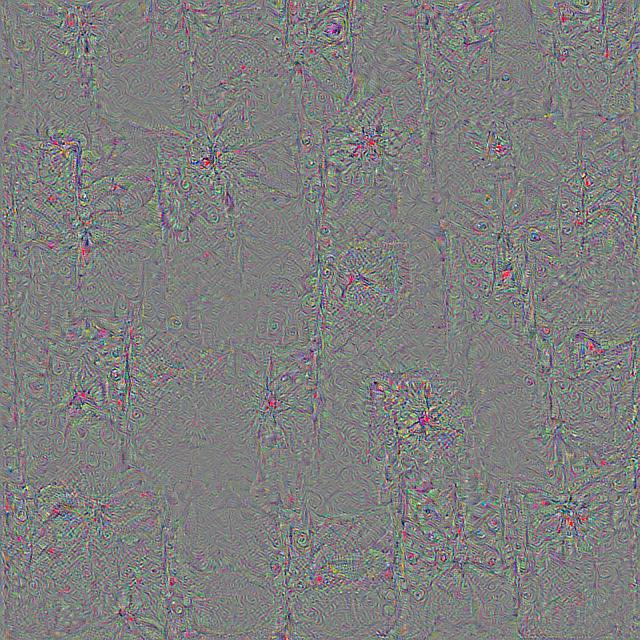

In [4]:
-

<a id="multiscale"></a>
## Multiscale image generation

Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradient ascent on multiple scales. Details formed on smaller scale will be upscaled and augmented with additional details on the next scale.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallpaper-sized images. Storing network activations and backprop values will quickly run out of GPU memory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying random shifts to the image before every iteration helps avoid tile seams and improves the overall image quality.

In [9]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

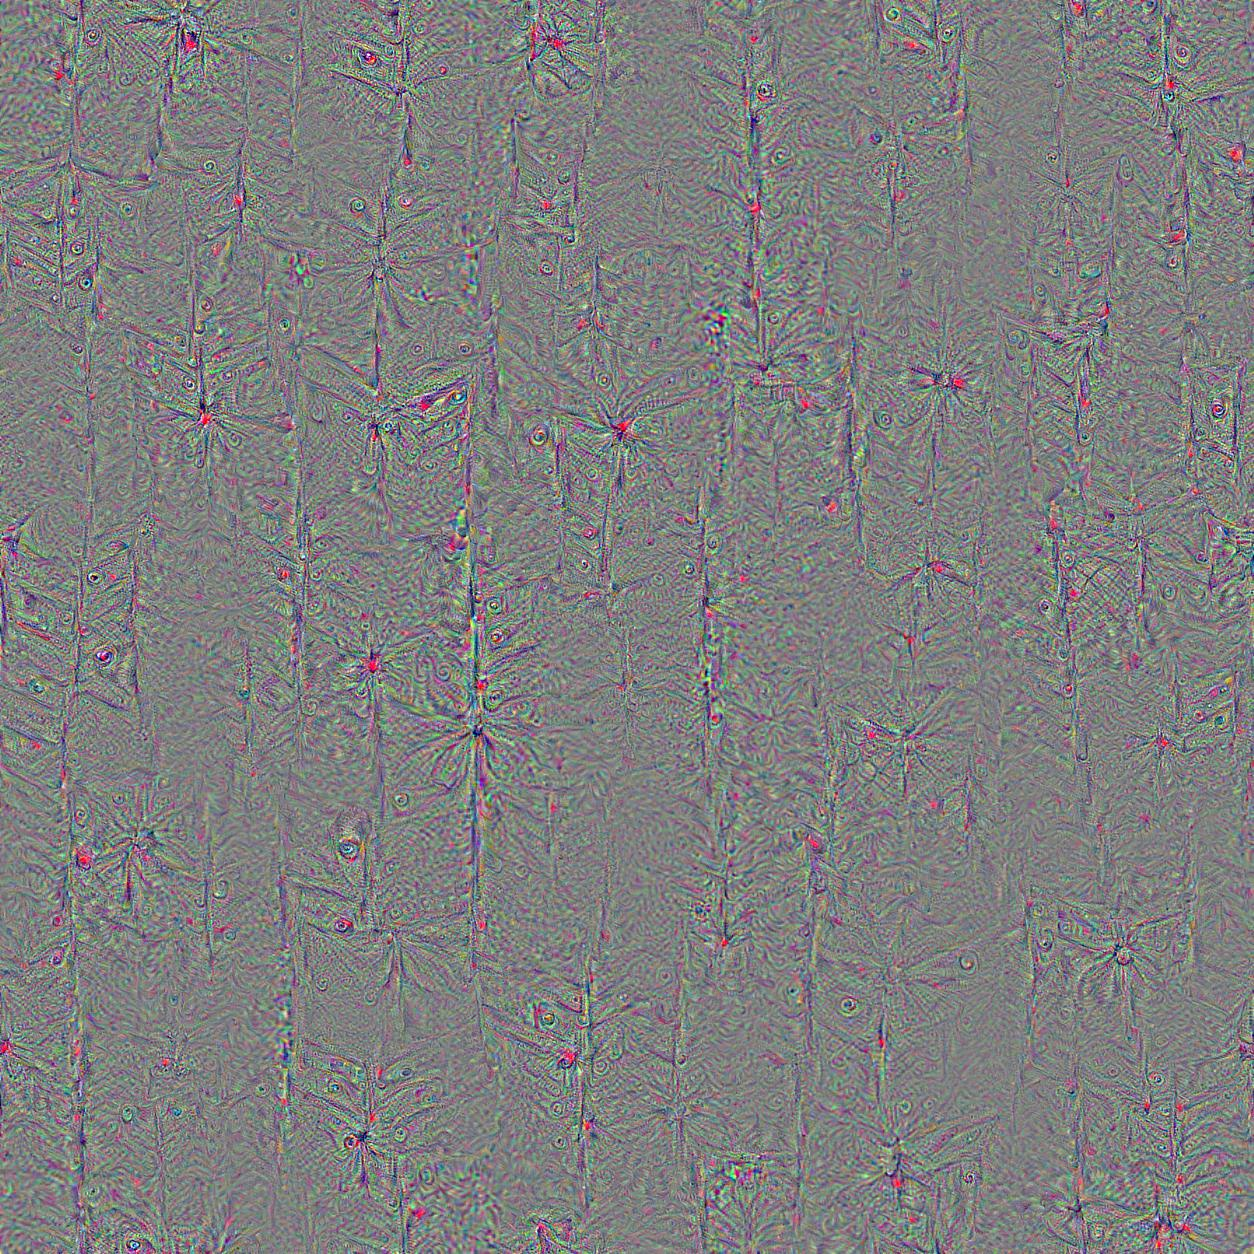

In [16]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            #print('.', img, end = ' ')
            print('.', octave, i, end = ' ')
        clear_output()
        showarray(visstd(img))

render_multiscale(T(layer)[:,:,:,channel])

<a id="laplacian"></a>
## Laplacian Pyramid Gradient Normalization

This looks better, but the resulting images mostly contain high frequencies. Can we improve it? One way is to add a smoothness prior into the optimization objective. This will effectively blur the image a little every iteration, suppressing the higher frequencies, so that the lower frequencies can catch up. This will require more iterations to produce a nice image. Why don't we just boost lower frequencies of the gradient instead? One way to achieve this is through the [Laplacian pyramid](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid) decomposition. We call the resulting technique _Laplacian Pyramid Gradient Normalization_.

In [6]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)

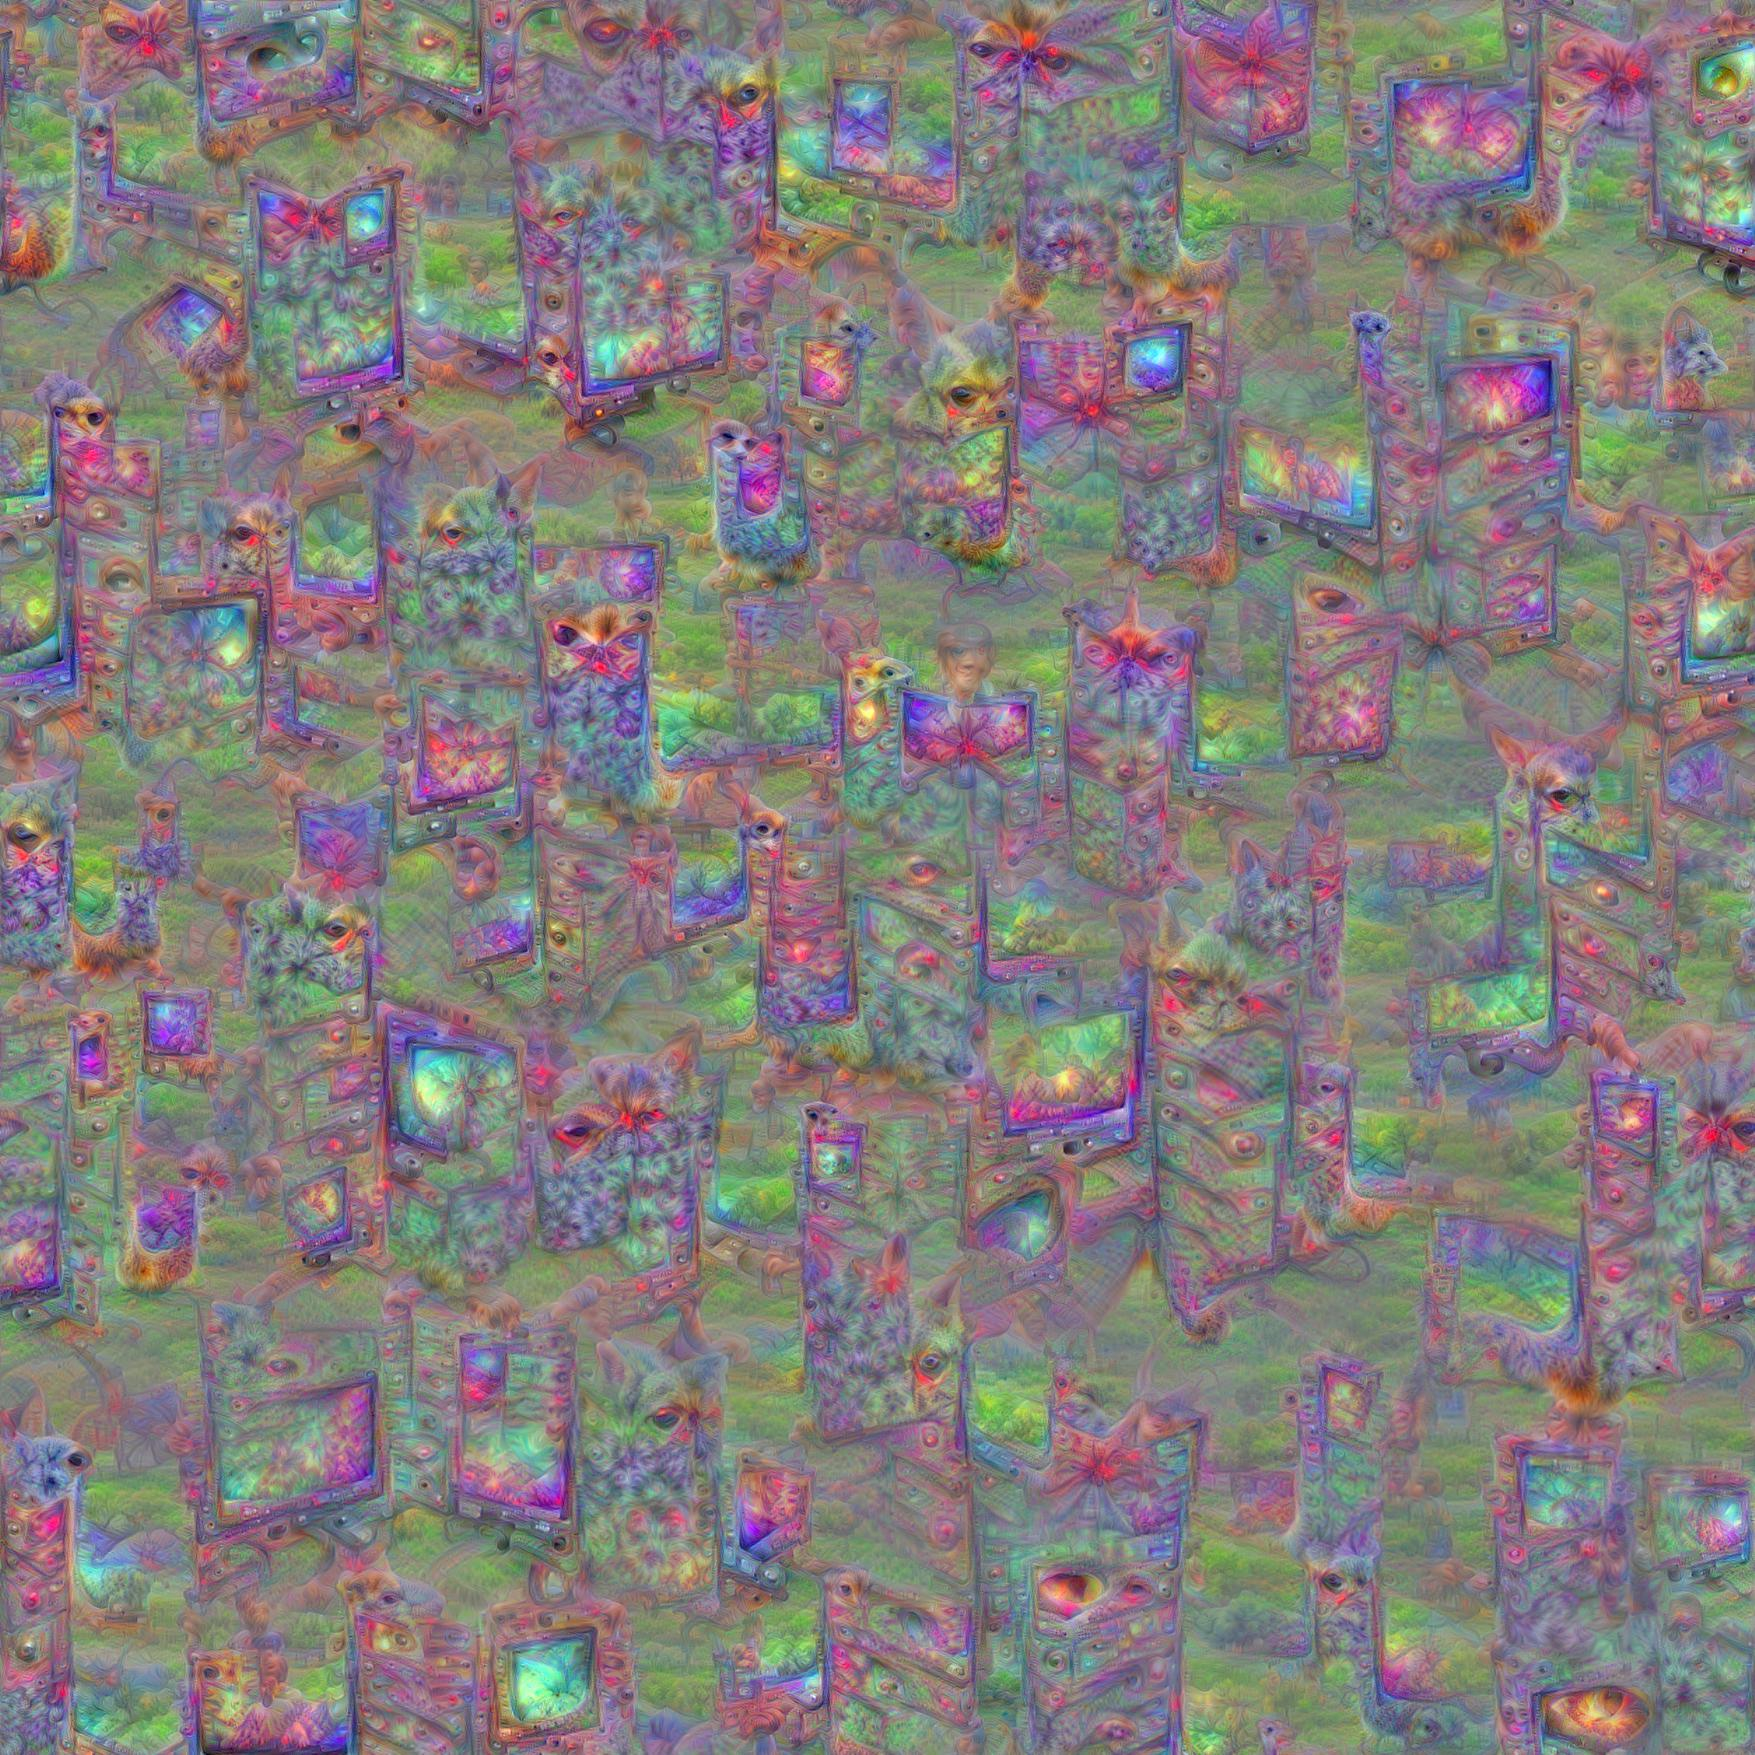

. 0 4 . 1 4 . 2 4 . 3 4 . 4 4 . 5 4 . 6 4 . 7 4 . 8 4 . 9 4 . 10 4 . 11 4 . 12 4 . 13 4 . 14 4 . 15 4 . 16 4 . 17 4 

KeyboardInterrupt: 

In [19]:
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=30, step=1.0, octave_n=8, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            #print('.', end = ' ')
            print('.', i, octave, end = ' ')
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,:,:,channel])

<a id="playing"></a>
## Playing with feature visualizations

We got a nice smooth image using only 10 iterations per octave. In case of running on GPU this takes just a few seconds. Let's try to visualize another channel from the same layer. The network can generate wide diversity of patterns.

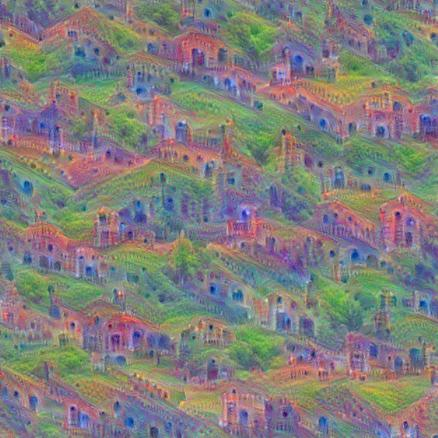

In [77]:
render_lapnorm(T(layer)[:,:,:,65])

Lower layers produce features of lower complexity.

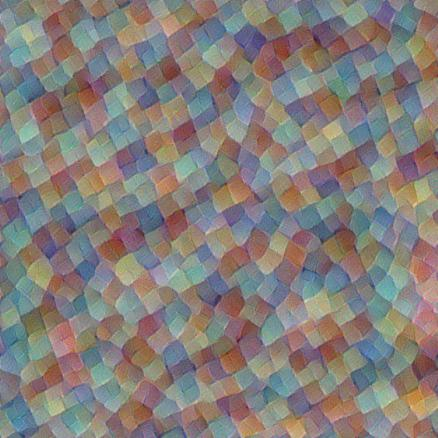

In [78]:
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

There are many interesting things one may try. For example, optimizing a linear combination of features often gives a "mixture" pattern.

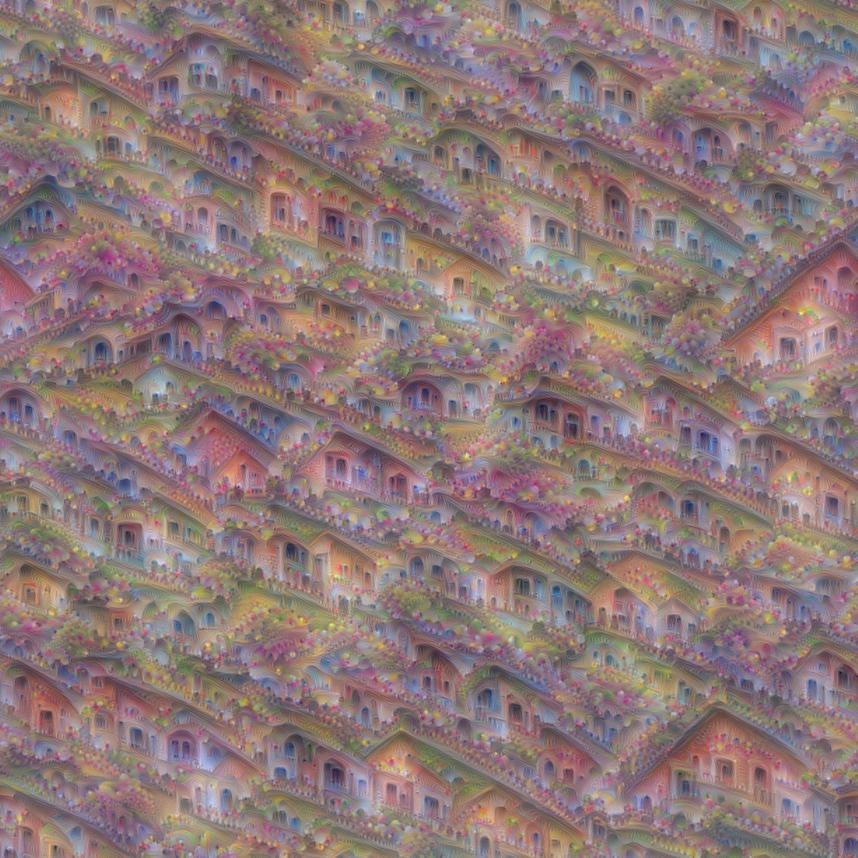

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
render_lapnorm(T(layer)[:,:,:,65]+T(layer)[:,:,:,139], iter_n=50 ,octave_n=8)

<a id="deepdream"></a>
## DeepDream

Now let's reproduce the [DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with TensorFlow. 


In [10]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)

In [14]:
!cp Screenshot\ from\ 2017-05-13\ 10-02-01.png  /notebooks/use.png


width = img.size[0]
height = img.size[1]
img3 = img.crop(
    (
        width - 612,
        height - 612,
        width,
        height
    )
)
img3.save("img3.jpg")

In [11]:
from PIL import Image

# Load the original image:
img = Image.open("out2.jpg")


Let's load some image and populate it with DogSlugs (in case you've missed them).

In [27]:
!ls 

0005.jpg
200.txt
3_deepdream.ipynb
640_lake-jocassee.jpg
ADream-0000.jpg
ADream-0001.jpg
ADream-0002.jpg
ADream-0003.jpg
AI_Composer-master.zip
ANTIALIAS.jpg
BICUBIC.jpg
BILINEAR.jpg
Bake_Your_Own.ipynb
Humber_estuary_foreshore_stormy_clouds_2.jpg
LICENSE
Labellio User Manual.html
Labellio User Manual_files
MathJax
NEAREST.jpg
PEM.sh
SIMPLESTART.sh
STUFF
Screenshot from 2017-05-13 10-02-01.png
TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
Untitled.ipynb
Untitled0.ipynb
Untitled2.ipynb
amino.mat
beach.jpg
bugs
bvlc_alexnet.npy
bvlc_googlenet
caffe-tensorflow
caffe_classes.py
caffe_classes.pyc
classify_image_graph_def.pb
clouds.jpg
costume277x277.jpg
crawler.ipynb
cropped_panda.jpg
deep_dream.py
deepdream.ipynb
deepdream2-Copy1.ipynb
deepdream2.ipynb
download (1).jpg
download (10).jpg
download (11).jpg
download (12).jpg
download (13).jpg
download (14).jpg
download (15).jpg
download (16).jpg
download (2).jpg
download (3).jpg
download (4).jpg
download (5).jpg
download (6).jpg
download (7).jpg
d

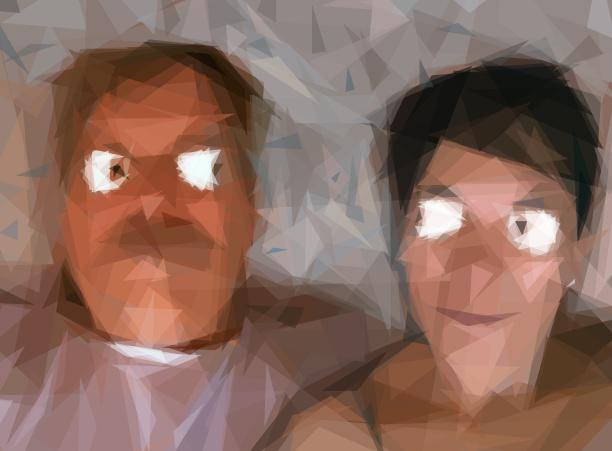

In [12]:
from IPython.display import clear_output, Image, display, HTML
img0 = PIL.Image.open('out2.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

In [38]:
# resize an image using the PIL image library
# free from:  http://www.pythonware.com/products/pil/index.htm
# tested with Python24        vegaseat     11oct2005
from PIL import Image
#import Image
# open an image file (.bmp,.jpg,.png,.gif) you have in the working folder
imageFile = "index.jpeg"
im1 = Image.open(imageFile)
# adjust width and height to your needs
width = 740
height = 740
# use one of these filter options to resize the image
im2 = im1.resize((width, height), Image.NEAREST)      # use nearest neighbour
im3 = im1.resize((width, height), Image.BILINEAR)     # linear interpolation in a 2x2 environment
im4 = im1.resize((width, height), Image.BICUBIC)      # cubic spline interpolation in a 4x4 environment
im5 = im1.resize((width, height), Image.ANTIALIAS)    # best down-sizing filter
ext = ".jpg"
im2.save("NEAREST-index" + ext)
im3.save("BILINEAR-index" + ext)
im4.save("BICUBIC-index" + ext)
im5.save("ANTIALIAS-index" + ext)
    


import PIL.image.size
image  ="out2.jpeg"
image.scale(640)

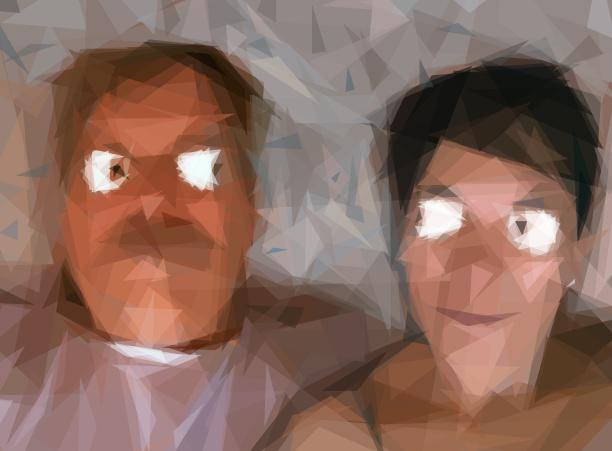

In [13]:
from IPython.display import clear_output, Image, display, HTML
img0 = PIL.Image.open('out2.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)
#showarray(img0)

In [14]:
def render_deepdream(t_obj, img0, iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)

In [90]:
import PIL
from PIL import Image
img = Image.open("640_lake-jocassee.jpg")

In [45]:
from PIL import Image
im=Image.open("scenery-at-lake-jocassee.jpg")
im.size # (width,height) tuple


(1920, 1275)

In [46]:
im = im.crop((0, 0,1275, 1275))
im.save("img6.jpg")

In [47]:
im=Image.open("img6.jpg")
im.size # (width,he

(1275, 1275)

In [48]:
# resize an image using the PIL image library
# free from:  http://www.pythonware.com/products/pil/index.htm
# tested with Python24        vegaseat     11oct2005
from PIL import Image
# open an image file (.bmp,.jpg,.png,.gif) you have in the working folder
imageFile = "img6.jpg"
im1 = Image.open(imageFile)
# adjust width and height to your needs
width = 640
height = 640
# use one of these filter options to resize the image
im2 = im1.resize((width, height), Image.NEAREST)      # use nearest neighbour
im3 = im1.resize((width, height), Image.BILINEAR)     # linear interpolation in a 2x2 environment
im4 = im1.resize((width, height), Image.BICUBIC)      # cubic spline interpolation in a 4x4 environment
im5 = im1.resize((width, height), Image.ANTIALIAS)    # best down-sizing filter
ext = ".jpg"
im2.save("NEAREST" + ext)
im3.save("BILINEAR" + ext)
im4.save("BICUBIC" + ext)
im5.save("ANTIALIAS" + ext)

In [18]:
!ls

0005.jpg				 notebooks
200.txt					 out.bmp
640_lake-jocassee.jpg			 out.jpg
LICENSE					 out2.jpg
MathJax					 out3.jpg
PEM.sh					 out_file.png
SIMPLESTART.sh				 out_file2.png
STUFF					 output640lakejocassee.jpg
Screenshot from 2017-05-13 10-02-01.png  root
Untitled.ipynb				 s000.png
Untitled0.ipynb				 s001.png
Untitled1.ipynb				 s002.png
Untitled2.ipynb				 s003.png
bvlc_googlenet				 s004.png
deepdream.ipynb				 s005.png
deepdream2-Copy1.ipynb			 s006.png
deepdream2.ipynb			 s007.png
experiments-APR29.ipynb			 s008.png
frames					 s009.png
good stuff.sh				 scenery-at-lake-jocassee.jpg
good stuff.txt				 serious thought .txt
home					 start-notebook.sh
imagenet_comp_graph_label_strings.txt	 start.sh
img2.jpg				 start_PEM.sh
img3.jpg				 tensorflow_inception_graph.pb
inception5h.zip				 test.ipynb
itest.py				 test.py
key.pem					 tf-graph-basic.build.html
models					 tf-graph-basic.build.html.1
notebook.sh				 tf-graph-basic.build_files
notebook2.sh				 tmp.prototxt
notebooki

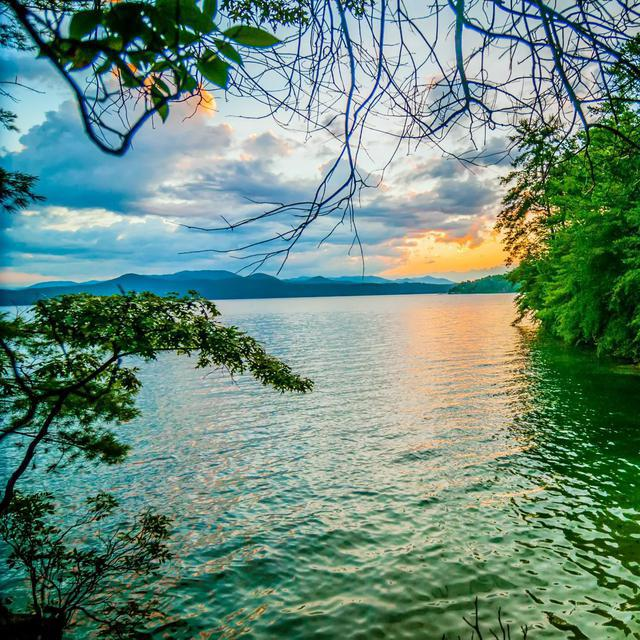

In [99]:
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
img0 = PIL.Image.open('ANTIALIAS.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

In [100]:
img = Image.open("/notebooks/use.png")

AttributeError: type object 'Image' has no attribute 'open'

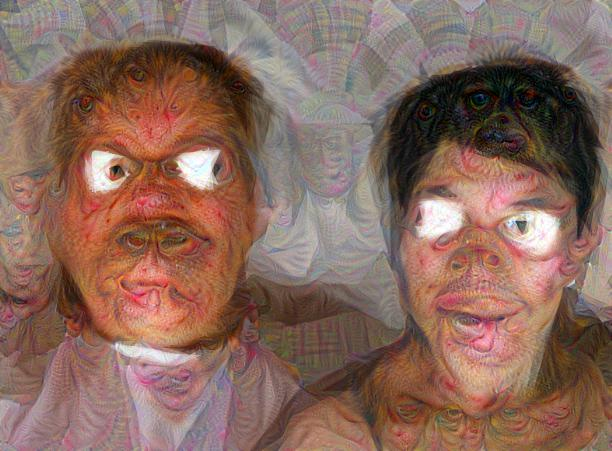

In [15]:
render_deepdream(tf.square(T('mixed4c')), img0)

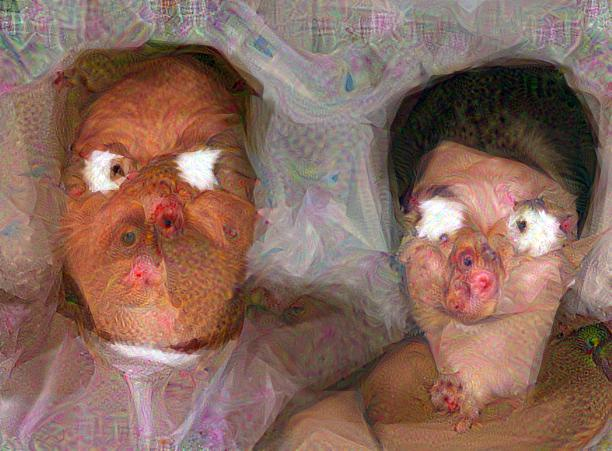

In [16]:
render_deepdream(tf.square(T('mixed5a_pool_reduce')), img0)

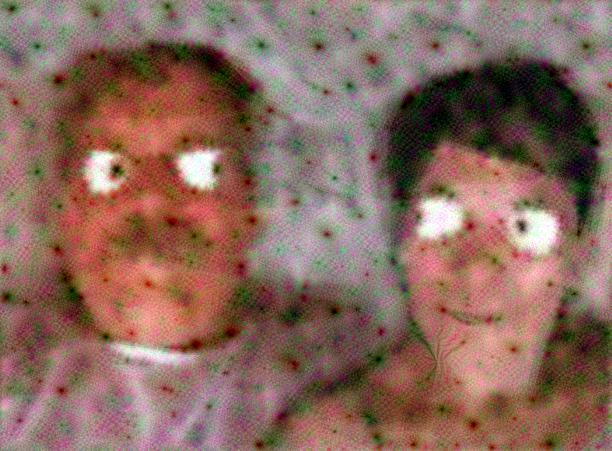

In [17]:
render_deepdream(tf.square(T('mixed3a_pool_reduce')), img0, iter_n=20 )

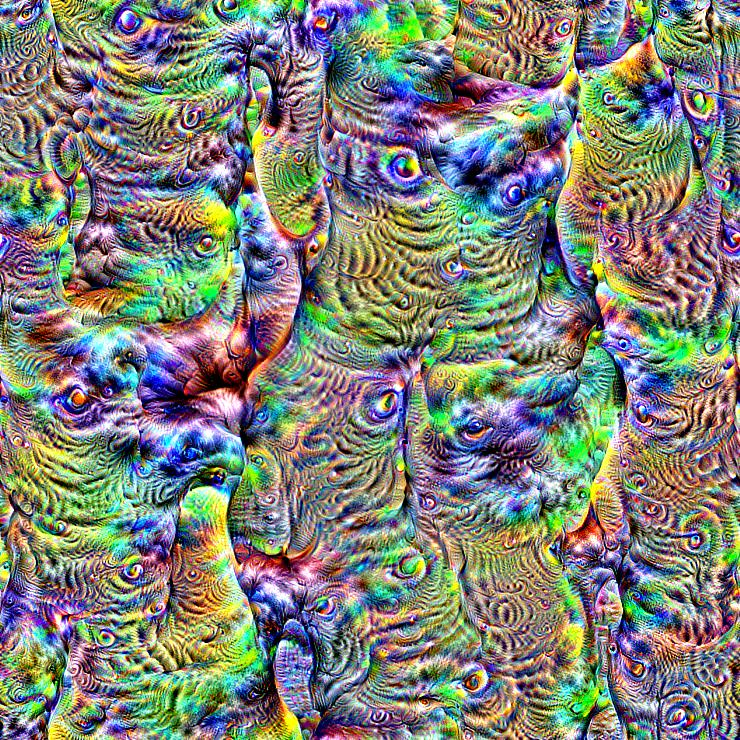

In [45]:
render_deepdream(tf.square(T('mixed5b_5x5')), img0, iter_n=250, octave_n=6 )

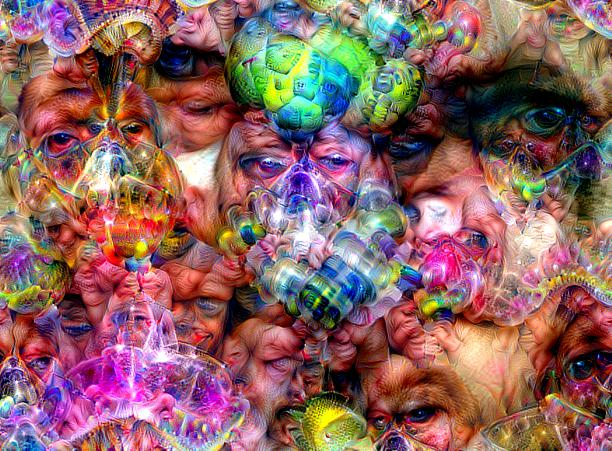

In [18]:
#render_lapnorm(T('mixed5b_pool'), img_noise, iter_n=50, octave_n=8, step=1.6, octave_scale=1.4, lap_n=4)


#render_lapnorm(img0, visfunc=visstd,
                  # iter_n=30, step=1.0, octave_n=8, octave_scale=1.4, lap_n=1)

#render_lapnorm(T('mixed5b_pool')[:,:,:,channel])

render_deepdream(tf.square(T('mixed5b_pool')), img0, iter_n=100, octave_n=8, step=1.6 )

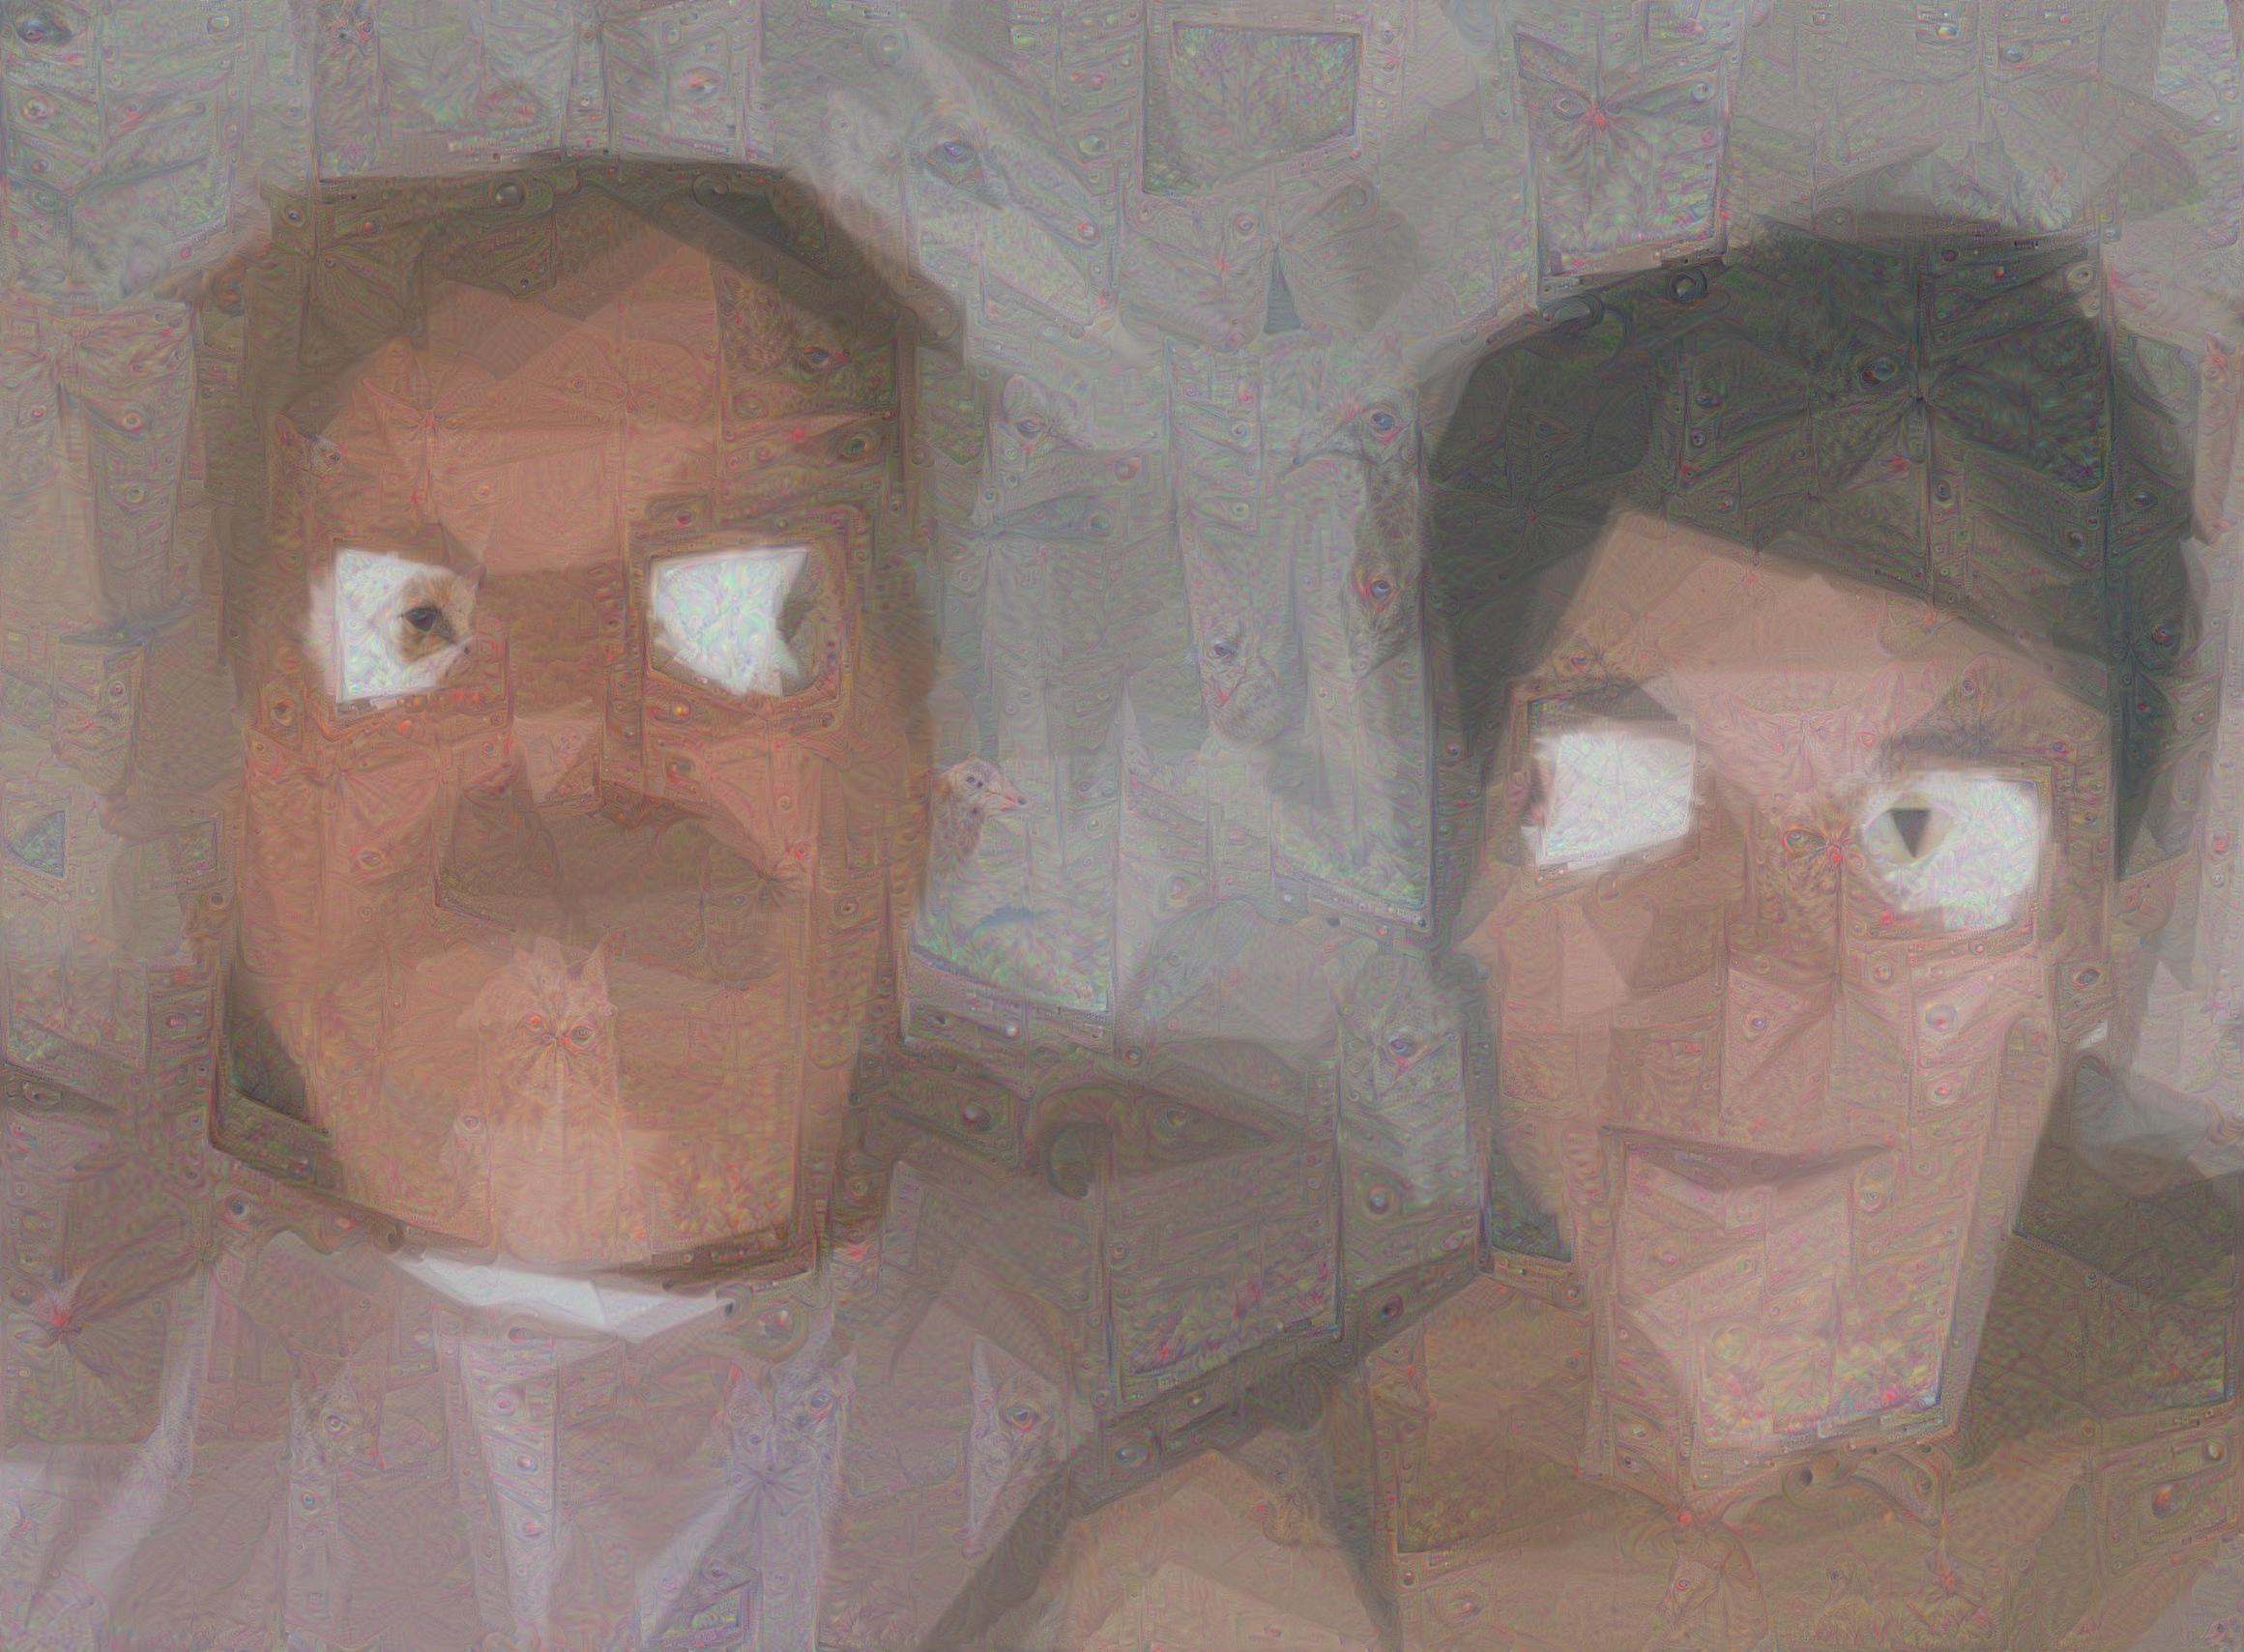

KeyboardInterrupt: 

In [21]:
def render_multiscale(t_obj, img0=img0, iter_n=200, step=1.6, octave_n=9, octave_scale=1.56):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))

render_multiscale(T('mixed5b_pool')[:,:,:,channel])

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXxx

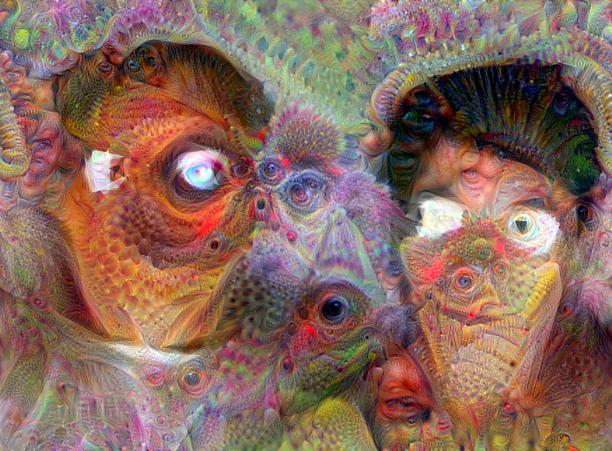

In [23]:
#img_noise = np.random.uniform(size=(750,750,3)) + 100.0    
render_deepdream(tf.square(T("mixed5b_pool")), img0, iter_n=20, octave_n=8, step=1.6 )

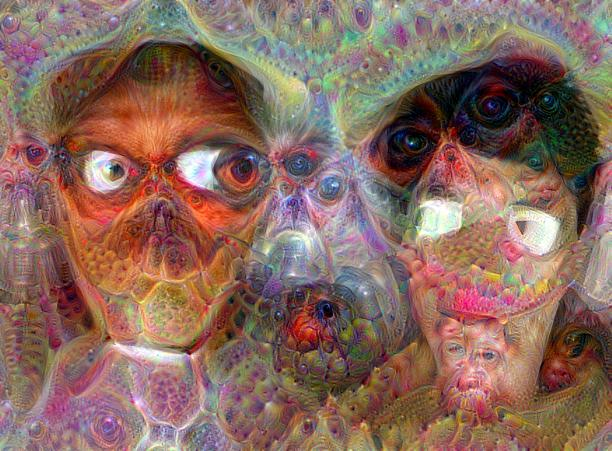

In [26]:
#img_noise = np.random.uniform(size=(750,750,3)) + 100.0    
render_deepdream(tf.square(T("mixed5a_3x3_bottleneck")), img0, iter_n=20, octave_n=8, step=1.6 )

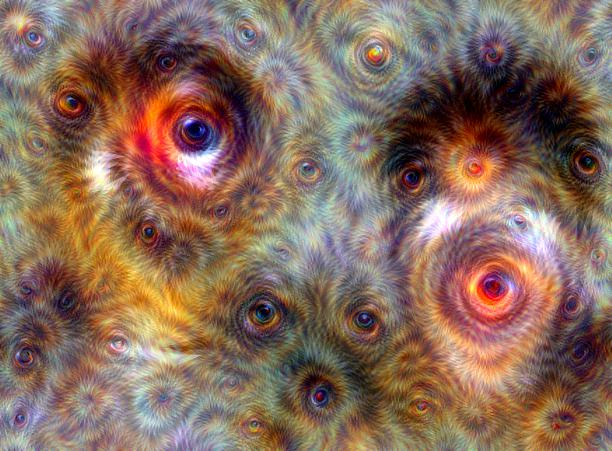

In [28]:
#img_noise = np.random.uniform(size=(750,750,3)) + 100.0    
render_deepdream(tf.square(T("mixed4a_pool_reduce")), img0, iter_n=20, octave_n=10, step=1.6 )

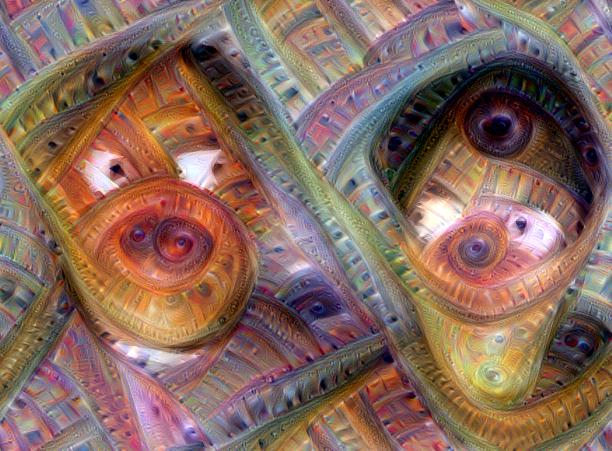

In [29]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(750,750,3)) + 100.0    
render_deepdream(tf.square(T("mixed4a_5x5_bottleneck_pre_relu")), img0, iter_n=20, octave_n=8, step=1.6 )

import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(750,750,3)) + 100.0    
render_deepdream(tf.square(T("mixed4a_5x5_bottleneck_pre_relu")), img_noise, iter_n=100, octave_n=9, step=1.6 )

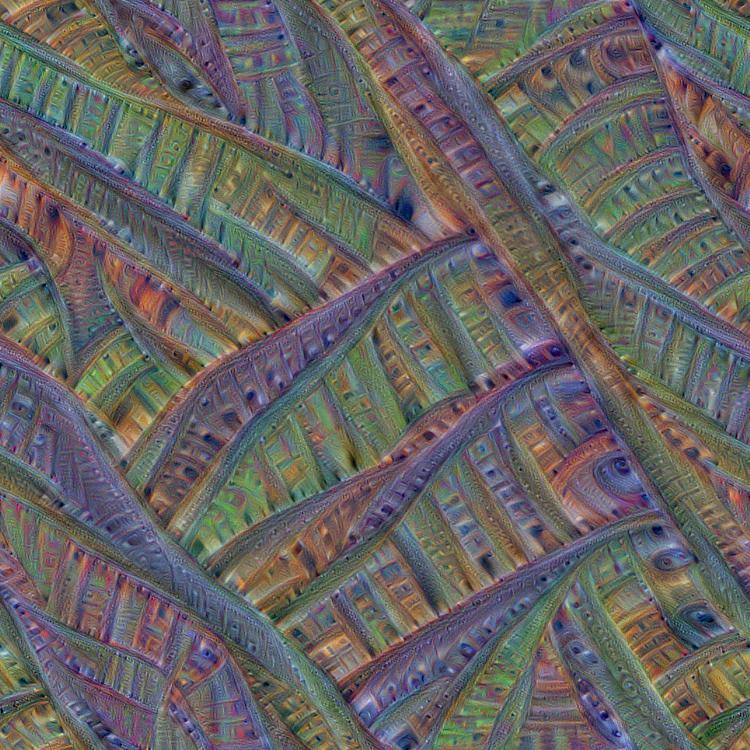

In [121]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(750,750,3)) + 100.0    
render_deepdream(tf.square(G("mixed4a_5x5_bottleneck_pre_relu")), img0, iter_n=20, octave_n=8, step=1.6 )

In [34]:
!ls test_saveTENSOR.jpg

ls: cannot access 'test_saveTENSOR.jpg': No such file or directory


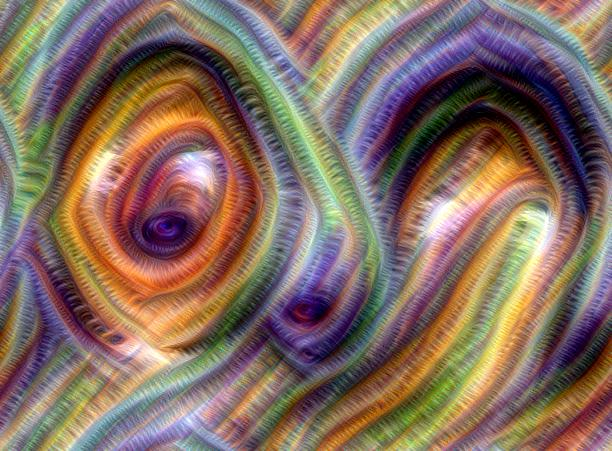

NameError: global name 'image' is not defined

In [32]:
def save_jpeg(jpeg_file, img0):
  pil_image = PIL.Image.fromarray(image)
  pil_image.save(jpeg_file)
  print('Saved to file: ', jpeg_file)
#FLAGS = tf.app.flags.FLAGS

#save_jpeg(FLAGS.jpeg_file, image)

im001 = render_deepdream(tf.square(T("mixed3b_5x5_bottleneck")), img0, iter_n=30, octave_n=9, step=1.6 )
#save_jpeg(FLAGS."test_save.jpg", im001)
save_jpeg("test_saveTENSOR.jpg", im001)

print (im001)

In [33]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(T("mixed4b_5x5_bottleneck")), img001, iter_n=15, octave_n=8, step=1.6 )

NameError: name 'img001' is not defined

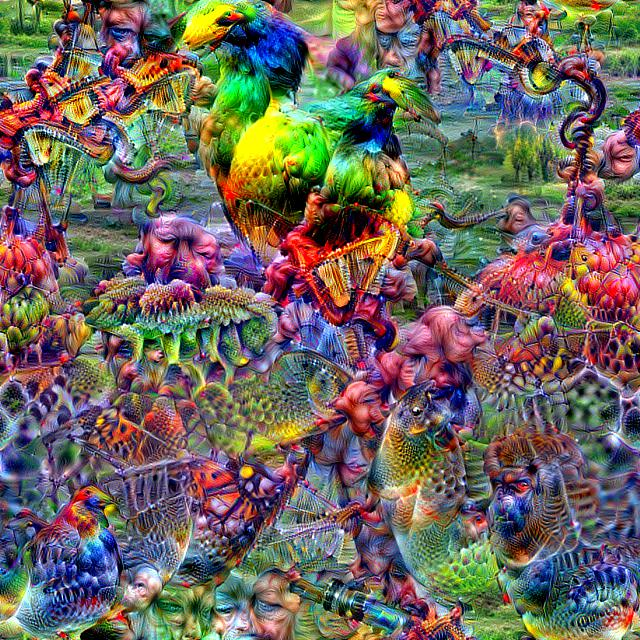

In [105]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=150, octave_n=8, step=1.6 )

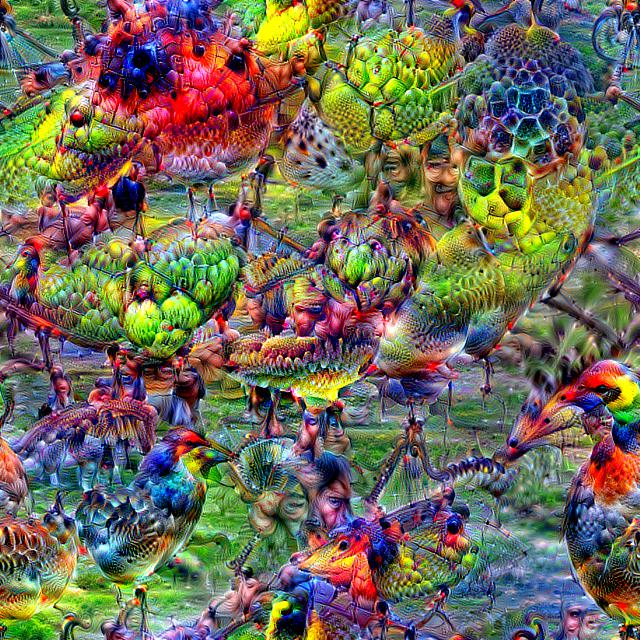

In [106]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=150, octave_n=8, step=1.6 )

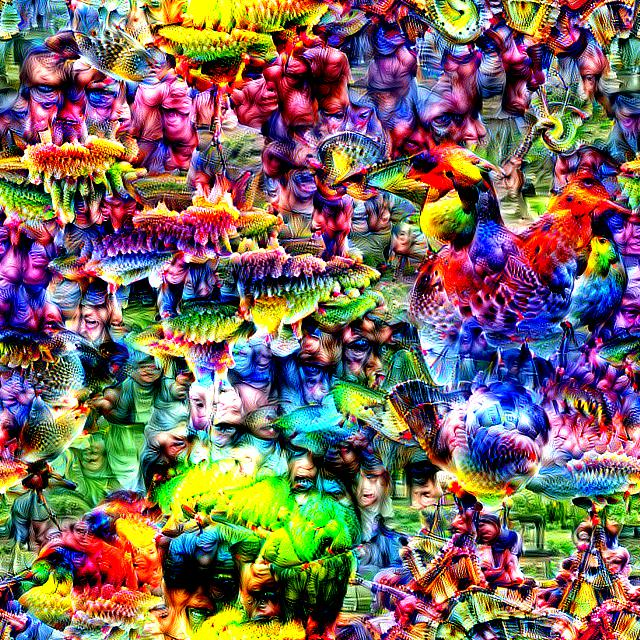

In [107]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=500, octave_n=8, step=1.6 )

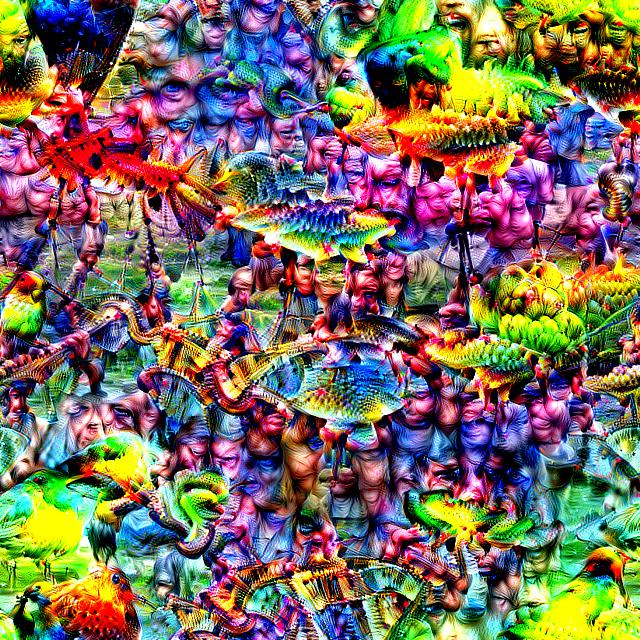

In [108]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=500, octave_n=8, step=1.6 )

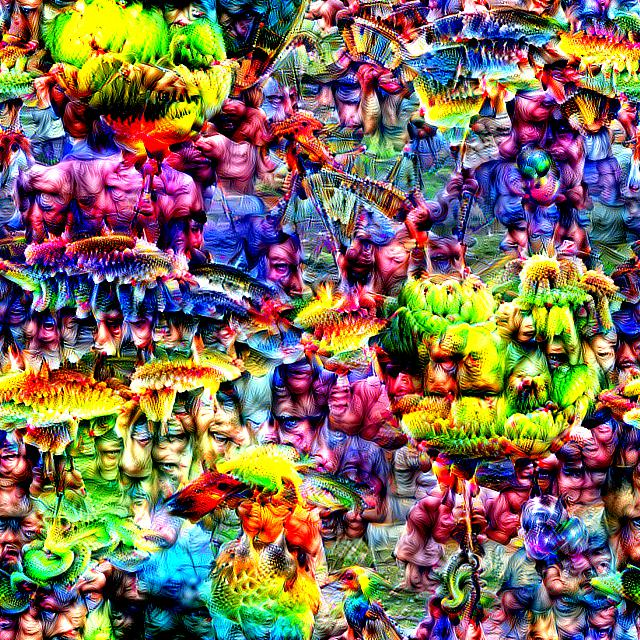

In [109]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=500, octave_n=8, step=1.6 )

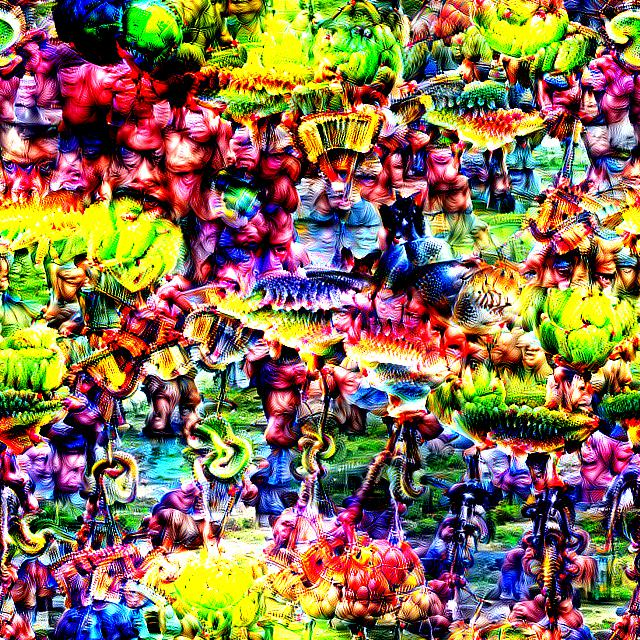

In [110]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=1000, octave_n=8, step=1.6 )

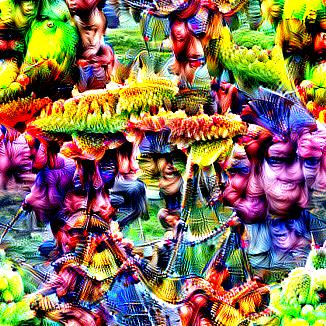

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

KeyboardInterrupt: 

In [111]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=100, octave_n=8, step=1.6 )

In [ ]:
import random
from datetime import datetime
random.seed(datetime.now())
img_noise = np.random.uniform(size=(640,640,3)) + 100.0    
render_deepdream(tf.square(G("mixed5b_pool")), img_noise, iter_n=1000, octave_n=8, step=1.6 )

Note that results can differ from the [Caffe](https://github.com/BVLC/caffe)'s implementation, as we are using an independently trained network. Still, the network seems to like dogs and animal-like features due to the nature of the ImageNet dataset.

Using an arbitrary optimization objective still works:

Note that results can differ from the [Caffe](https://github.com/BVLC/caffe)'s implementation, as we are using an independently trained network. Still, the network seems to like dogs and animal-like features due to the nature of the ImageNet dataset.

Using an arbitrary optimization objective still works:

# render_deepdream(T(layer)[:,:,:,139], img0)

In [ ]:
render_deepdream(T(layer)[:,:,:,139], img0, iter_n=50, octave_n=8)

In [ ]:
render_deepdream(T(layer)[:,:,:,139], img0)

In [43]:
!ls *.png

Screenshot from 2017-05-13 10-02-01.png  s000.png  s003.png  s006.png  s009.png
out_file.png				 s001.png  s004.png  s007.png
out_file2.png				 s002.png  s005.png  s008.png


In [ ]:
from PIL import Image
overlay = Image.open('/notebooks/a.png').convert("RGBA") 
overlay.load()
overlay.split()
base = Image.open('/notebooks/b.png').convert("RGBA")
base.load()
base.split()
"""
card = Image.new("RGBA", (220, 220), (255, 255, 255))
img = Image.open("/Users/paulvorobyev/test.png").convert("RGBA")
x, y = img.size
card.paste(img, (0, 0, x, y), img)
card.save("test.png", format="png")
"""

bands = list(overlay.split())
if len(bands) == 4:
    # Assuming alpha is the last band
    bands[3] = bands[3].point(lambda x: x*0.4)
overlay = Image.merge(overlay.mode, bands)

base.paste(overlay, (0, 0), overlay)
base.save('result.png')


In [ ]:
def DisplayFractal(a, fmt='jpeg'):
  """Display an array of iteration counts as a
     colorful picture of a fractal."""
  a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

Don't hesitate to use higher resolution inputs (also increase the number of octaves)! Here is an [example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg) of running the flower dream over the bigger image.

We hope that the visualization tricks described here may be helpful for analyzing representations learned by neural networks or find their use in various artistic applications.

import tensorflow as tf
import numpy as np

print("resizing images")

filenames = ['img1.png', 'img2.png' ]
filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)

reader = tf.WholeFileReader()
key,value = reader.read(filename_queue)
images = tf.image.decode_png(value)

resized = tf.image.resize_images(images, 180,180, 1)
resized.set_shape([180,180,3])

flipped_images = tf.image.flip_up_down(resized)

resized_encoded = tf.image.encode_jpeg(flipped_images,name="save_me")

init = tf.initialize_all_variables()
sess = tf.Session()

with sess.as_default():
  tf.train.start_queue_runners()
  sess.run(init)

  f = open("/tmp/foo1.jpeg", "wb+")
  f.write(resized_encoded.eval())
  f.close()

  f = open("/tmp/foo2.jpeg", "wb+")
  f.write(resized_encoded.eval())
  f.close()

In [45]:
sess.graph.get_operations()

[<tf.Operation 'input' type=Placeholder>,
 <tf.Operation 'sub/y' type=Const>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'ExpandDims/dim' type=Const>,
 <tf.Operation 'ExpandDims' type=ExpandDims>,
 <tf.Operation 'import/input' type=Placeholder>,
 <tf.Operation 'import/conv2d0_w' type=Const>,
 <tf.Operation 'import/conv2d0_b' type=Const>,
 <tf.Operation 'import/conv2d1_w' type=Const>,
 <tf.Operation 'import/conv2d1_b' type=Const>,
 <tf.Operation 'import/conv2d2_w' type=Const>,
 <tf.Operation 'import/conv2d2_b' type=Const>,
 <tf.Operation 'import/mixed3a_1x1_w' type=Const>,
 <tf.Operation 'import/mixed3a_1x1_b' type=Const>,
 <tf.Operation 'import/mixed3a_3x3_bottleneck_w' type=Const>,
 <tf.Operation 'import/mixed3a_3x3_bottleneck_b' type=Const>,
 <tf.Operation 'import/mixed3a_3x3_w' type=Const>,
 <tf.Operation 'import/mixed3a_3x3_b' type=Const>,
 <tf.Operation 'import/mixed3a_5x5_bottleneck_w' type=Const>,
 <tf.Operation 'import/mixed3a_5x5_bottleneck_b' type=Const>,
 <tf.Operation '

In [61]:
!pip install fipy

    100% |################################| 5.6MB 27kB/s ta 0:00:011
  Running setup.py bdist_wheel for fipy ... done
  Stored in directory: /root/.cache/pip/wheels/92/b5/31/ec3e8782bc68664fc74b66714b18f0b1fdc17f1ac15b2b9924
Successfully built fipy


0.951056516295
Consider graph. Press return to terminate program...-3,12,-45,6,6,-3


'-3,12,-45,6,6,-3'

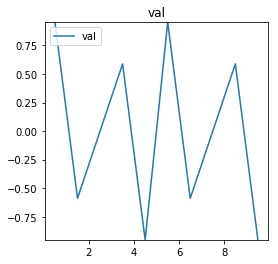

In [64]:
from fipy import *
from scipy import interpolate
import numpy as np
 
mesh = Grid1D(dx=3, nx=10)
 
datx = mesh.cellCenters[0]
daty = np.sin(4*np.pi*datx/10)
 
valumesh = Grid1D(dx=1, nx=10)
valu = CellVariable(name="val", mesh=valumesh)
x = mesh.cellCenters[0]
 
liny = interpolate.interp1d(datx, daty, kind='linear')
 
print (liny(1.5))
 
valu.setValue(liny(x), where=np.ones(10))
 
view = Viewer(vars=(valu,))
view.plot()
raw_input("Consider graph. Press return to terminate program...")

In [76]:
!pip install requests

    100% |################################| 563kB 176kB/s ta 0:00:01
